<a href="https://colab.research.google.com/github/CheesyPitsa/lab2.4/blob/main/lab4_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 23138, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 23138 (delta 32), reused 75 (delta 23), pack-reused 23038
Receiving objects: 100% (23138/23138), 42.20 MiB | 27.11 MiB/s, done.
Resolving deltas: 100% (12685/12685), done.
Updating files: 100% (2762/2762), done.


In [5]:

import tensorflow as tf
import tensorflow_datasets as tfds
from examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
from tensorflow import keras
from tensorflow.keras import activations
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras import utils


In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8NHV98/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8NHV98/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [8]:
def load_train(dataset):
  input_image = tf.image.resize(dataset['image'], size=(width, height))
  input_mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask


In [9]:
def load_test(dataset):
  input_image = tf.image.resize(dataset['image'], size=(width, height))
  input_mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))
  
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [10]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
width, height = 224, 224

In [11]:
train_images = dataset['train'].map(load_train, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_test, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [13]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [14]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

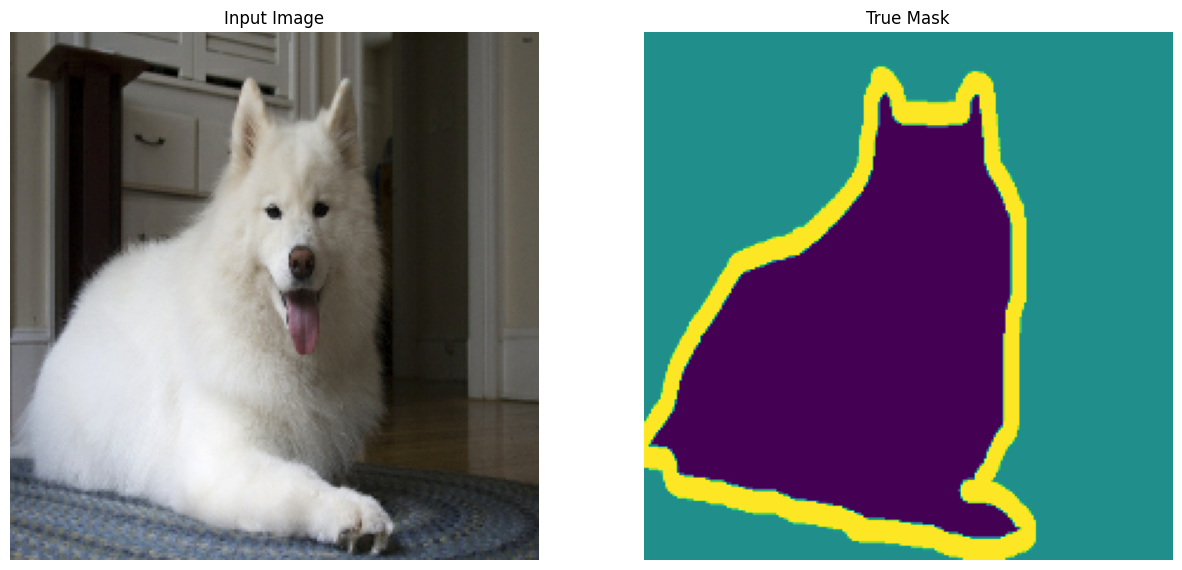

In [15]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [16]:
base_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(width, height, 3))

layer_names = [
               'block1_pool',
               'block2_pool',
               'block3_pool',
               'block4_pool',
               'block5_pool',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input, base_model_outputs)

58889256/58889256 [==============================] - 0s 0us/step


In [17]:

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [18]:
def fcn8_decoder(convs, n_classes):
  f1, f2, f3, f4, p5 = convs

  n = 4096
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  f5 = c7

  # увеличиваем выборку выходных данных кодировщика, потом обрезаем дополнительные пиксели, которые были введены
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # прогноз пула 4 и свертка 1x1
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # результаты расширенной выборки и прогноза пула 4
  o = tf.keras.layers.Add()([o, o2])

  # пример результирующего тензора операции
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # прогноз пула 3 и свертка 1x1
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # результаты расширенной выборки и прогнозирования пула 3
  o = tf.keras.layers.Add()([o, o2])
  
  # увеличение образца до размера исходного изображения
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
  o = tf.keras.layers.Activation('softmax')(o)
  return o

In [19]:
def segmentation_model():
  
  inputs = keras.layers.Input(shape = (width, height, 3)) 
  convs = VGG_16(inputs)
  outputs = fcn8_decoder(convs, 3)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  
  return model

In [20]:
opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

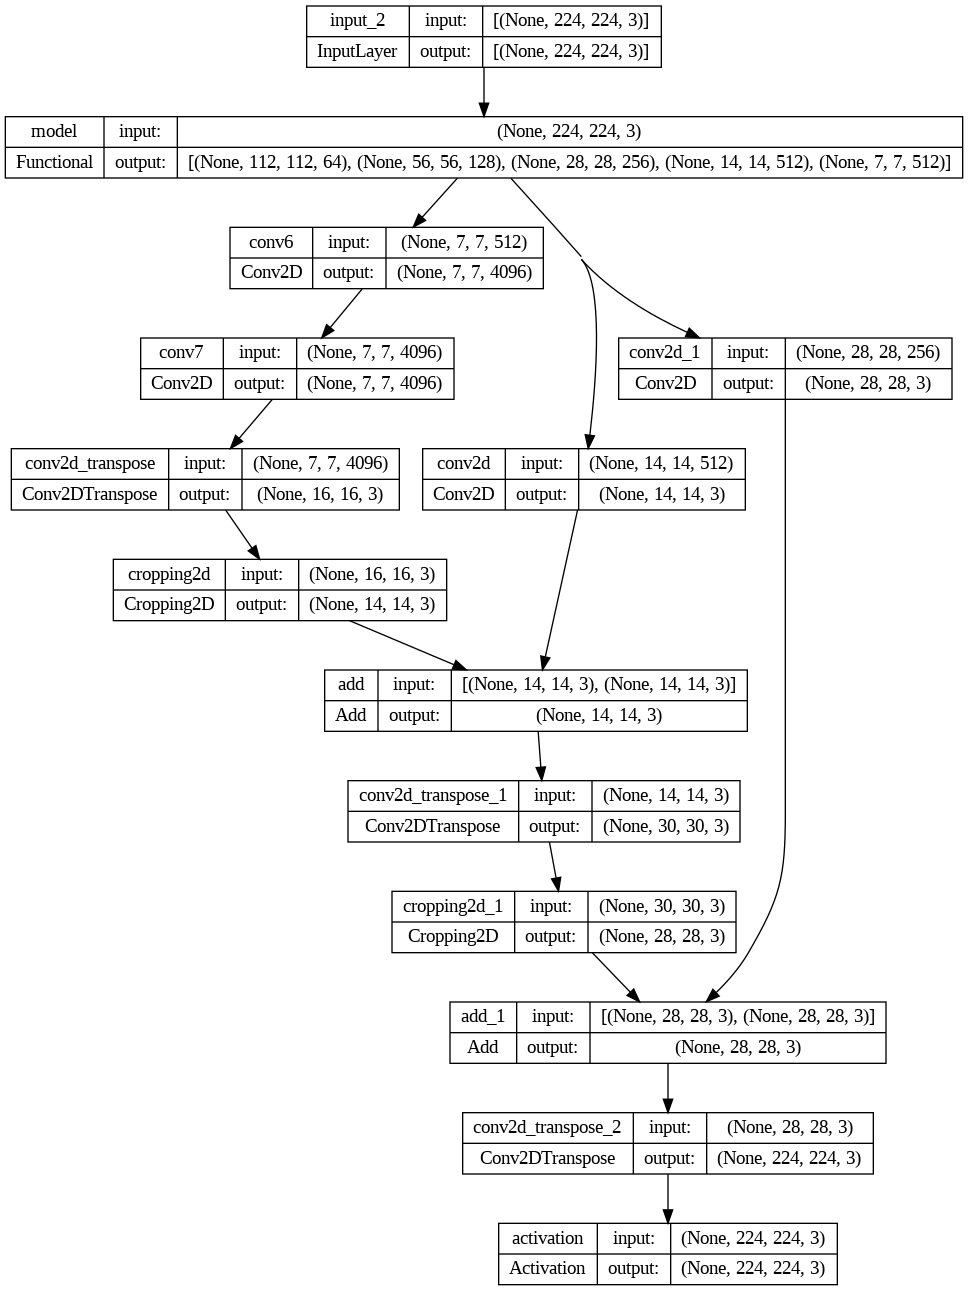

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [23]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 15s 16ms/step


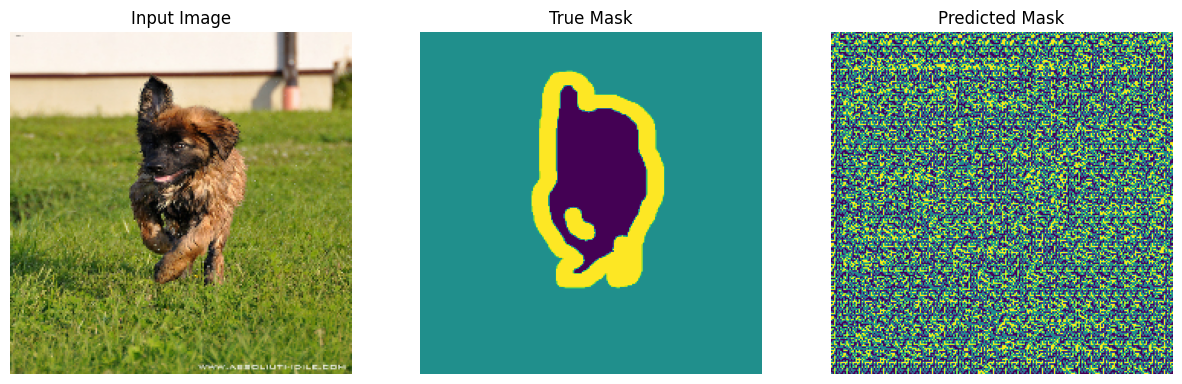

2/2 [==============================] - 0s 313ms/step


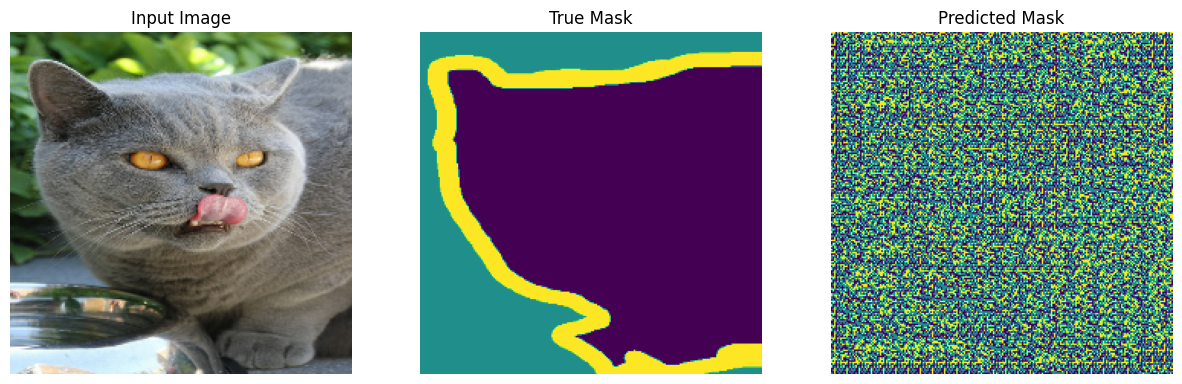

2/2 [==============================] - 0s 237ms/step


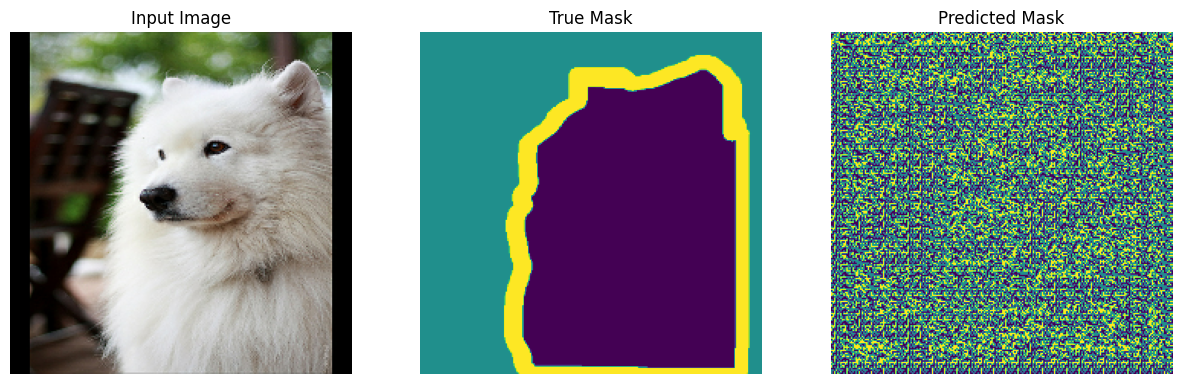

In [24]:
show_predictions(test_batches, 3)

1/1 [==============================] - 0s 29ms/step


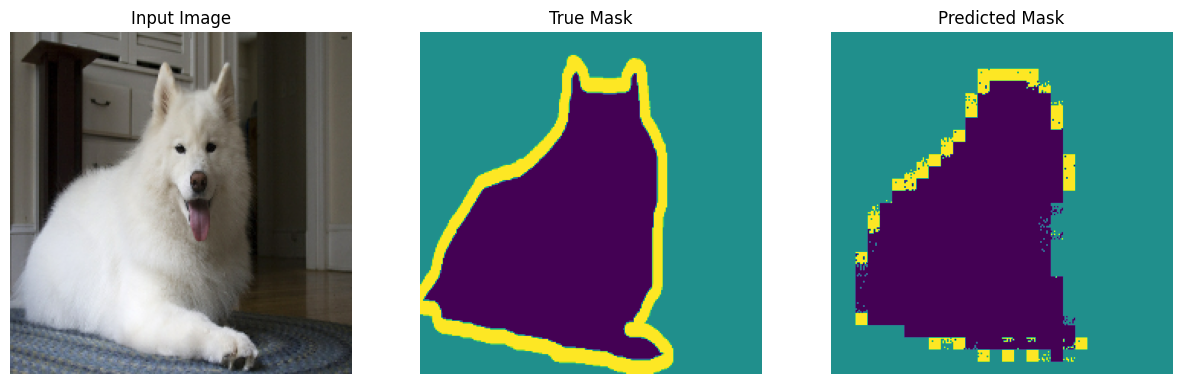


Sample Prediction after epoch 7

57/57 [==============================] - 50s 872ms/step - loss: 0.3312 - accuracy: 0.8535 - val_loss: 0.3782 - val_accuracy: 0.8415


In [25]:
EPOCHS = 7
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])